# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.78KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

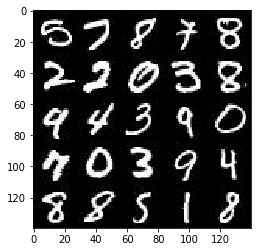

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

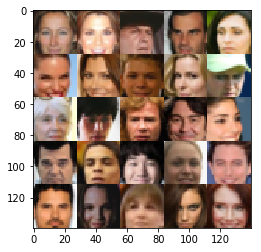

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, (None), name = 'learning_rate')
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
            
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
      
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = True)
        relu4 = tf.maximum(alpha * x4, x4)
        
      
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits 



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    if is_train == True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse = reuse):
       
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides = 1, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides = 2, padding = 'same')
       
        output = tf.tanh(logits) 
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    is_train = tf.placeholder(tf.bool)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 3.7350
Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 2.3730... Generator Loss: 0.1463
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 1.2947
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 1.3413


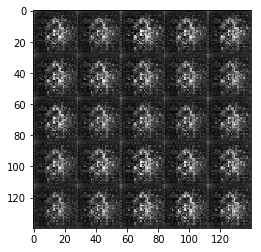

Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 5.0210
Epoch 1/2... Discriminator Loss: 0.4517... Generator Loss: 3.8536
Epoch 1/2... Discriminator Loss: 0.4142... Generator Loss: 1.7336
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 2.5614
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.6486... Generator Loss: 1.8445
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 3.3974
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 1.0088


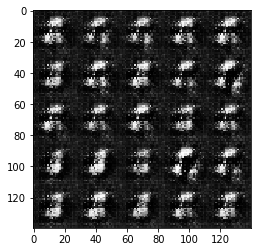

Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 1.7249
Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 2.0489
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 3.4833
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 2.5509
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 2.1156
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 2.0338
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 2.1538
Epoch 1/2... Discriminator Loss: 0.3334... Generator Loss: 1.9760
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 0.9909


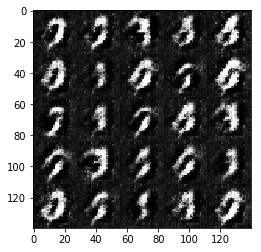

Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 3.5602
Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 1.5262
Epoch 1/2... Discriminator Loss: 0.7005... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.9448
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.0996


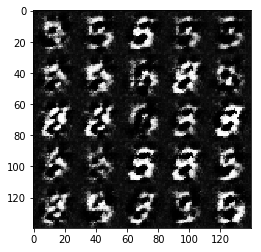

Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 2.6304
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.9420
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 4.4068
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 2.0229
Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 1.6277
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.5509
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.7470
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 2.6407
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.5622


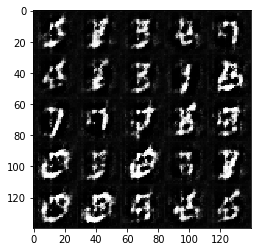

Epoch 1/2... Discriminator Loss: 0.8689... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 2.7153
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 1.7805
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.1897
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 1.8813
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 2.3618
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.5486


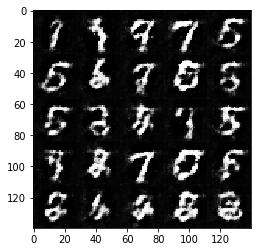

Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.8346
Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 1.1232
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.8238
Epoch 1/2... Discriminator Loss: 0.7986... Generator Loss: 1.0378
Epoch 1/2... Discriminator Loss: 2.0647... Generator Loss: 0.1859
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.4440
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.3969
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.3369


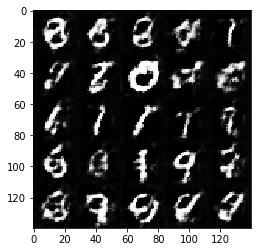

Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.5449
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 1.6827
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.2045
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.2969


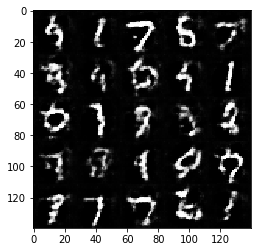

Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.5630
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 1.5019
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 1.6227
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 2.2612
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.5447... Generator Loss: 0.3091


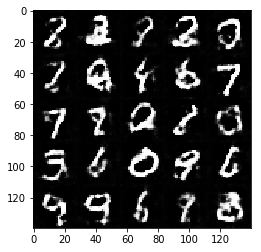

Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.4282
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.5386... Generator Loss: 0.3263
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.0088


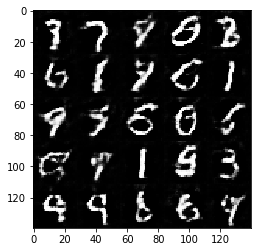

Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 1.1940... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.3861


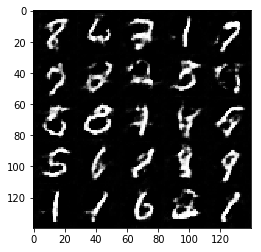

Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 1.6878
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.6842... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.5028
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.3662


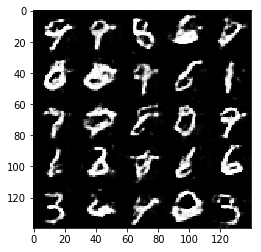

Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.4358
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 1.6259
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.0093
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 1.9736... Generator Loss: 0.1710


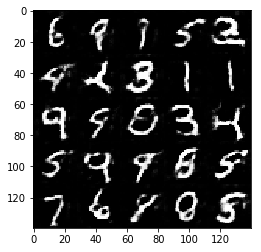

Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.4685
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.2789
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.3122
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.3580
Epoch 2/2... Discriminator Loss: 1.6148... Generator Loss: 0.2825
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.3474


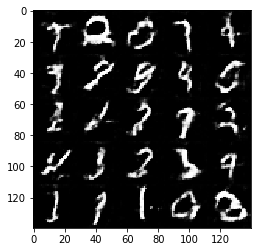

Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.8973... Generator Loss: 0.2019
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.3950
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.1998
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.6582... Generator Loss: 0.2753


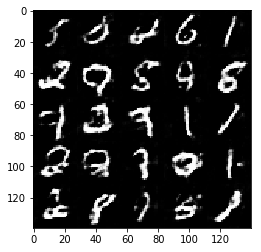

Epoch 2/2... Discriminator Loss: 2.0333... Generator Loss: 0.1722
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.7766... Generator Loss: 0.2216
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.6969
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 0.2609
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.3441


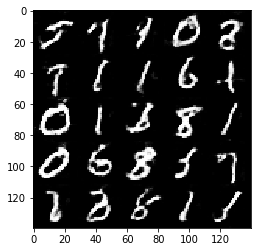

Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.6428... Generator Loss: 0.2693
Epoch 2/2... Discriminator Loss: 1.9499... Generator Loss: 0.2039
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.3799
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.4609
Epoch 2/2... Discriminator Loss: 1.6814... Generator Loss: 0.2669
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.3879
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.8717


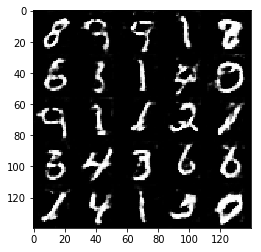

Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.3396
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.4065


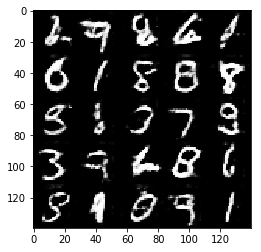

Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.5598... Generator Loss: 0.2963
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.4771


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 2.6716
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 0.9629


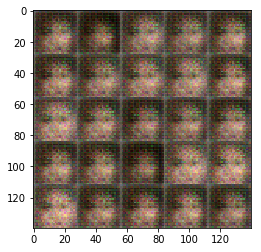

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.1724


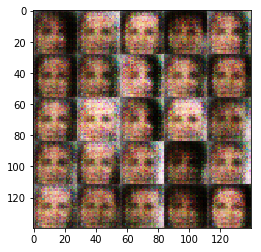

Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.8385


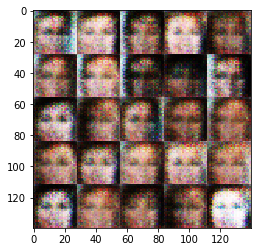

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0579


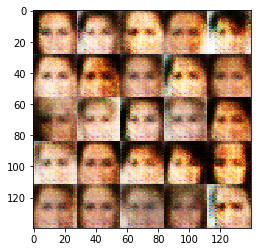

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.7036


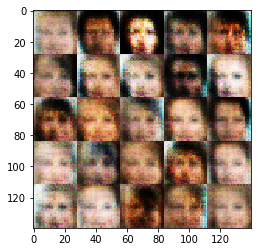

Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7779


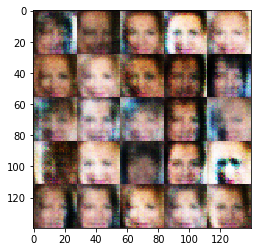

Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7338


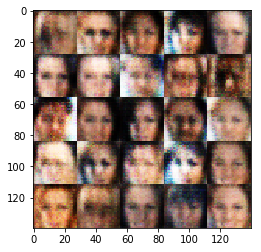

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7305


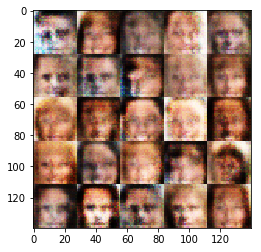

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7695


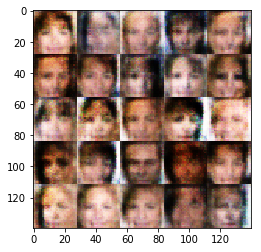

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.5570


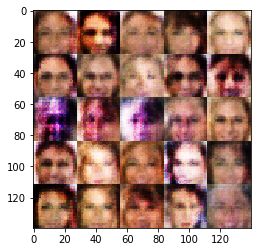

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7887


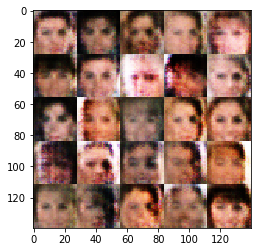

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.8200


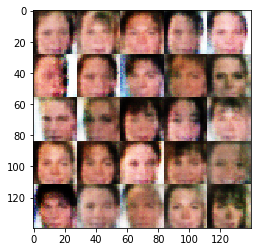

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7197


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.